In [1]:
import logging

import pandas as pd

from data.handler.EventLogHandler import EventLogHandler
from utils.Path import Path

logging.basicConfig(level=logging.WARNING)

handler = EventLogHandler()
handler.load(str(Path(['resources', 'test_logs', 'bpi2011_small.xes'])))

parsing log, completed traces ::   0%|          | 0/92 [00:00<?, ?it/s]

In [2]:
import datetime
import copy

from ml.encoding.EventLogEncodingBuilder import EventLogEncodingBuilder
from ml.encoding.intercase.AverageDelay import AverageDelay
from ml.encoding.intercase.FrequentPreviousActivity import FrequentPreviousActivity
from ml.encoding.intercase.FutureBatchingBehaviour import FutureBatchingBehaviour
from ml.encoding.intercase.NoPeerCases import NoPeerCases
from ml.encoding.intercase.PeerActivityCount import PeerActivityCount
from ml.encoding.intercase.ResourceCount import ResourceCount
from ml.encoding.intercase.TopBusyResource import TopBusyResource
from ml.encoding.intracase.IndexBasedEncoder import IndexBasedEncoder
from ml.classifier.NGram import NGram

def get_full_dataframe(handler_, timedelta_, min_batch_size_=10, max_delay_factor_=0.1):
    handler_ = copy.deepcopy(handler_)
    handler_.mine_batching_patterns(min_batch_size=min_batch_size_, max_delay=max_delay_factor_ * timedelta_)

    ngram = NGram(max_classes=len(handler_.process_definition))
    ngram_builder = EventLogEncodingBuilder() \
        .add(IndexBasedEncoder(window=4))


    X_ngram, y_ngram = ngram_builder.build(handler_)

    ngram.fit(X_ngram, y_ngram)

    builder = EventLogEncodingBuilder() \
        .add(IndexBasedEncoder(window=4)) \
        .add(NoPeerCases(timeframe=timedelta_)) \
        .add(PeerActivityCount(timeframe=timedelta_)) \
        .add(ResourceCount(timeframe=timedelta_)) \
        .add(AverageDelay(timeframe=timedelta_)) \
        .add(FrequentPreviousActivity(timeframe=timedelta_, no_activities=2, normalization=True)) \
        .add(TopBusyResource(timeframe=timedelta_, no_resources=2, normalization=True)) \
        .add(FutureBatchingBehaviour(segment_classifier=ngram, segment_encoding_builder=ngram_builder,
                                     include_average_times=False)) \

    X, y = builder.build(handler_)

    df_values = {}

    for j_ in range(4):
        df_values[f'index_based_{j_}'] = X[:, j_]
    df_values['peer_cases'] = X[:, 4]
    df_values['peer_act'] = X[:, 5]
    df_values['res_count'] = X[:, 6]
    df_values['avg_delay'] = X[:, 7]
    df_values['freq_act_1'] = X[:, 8]
    df_values['freq_act_2'] = X[:, 9]
    df_values['top_res_1'] = X[:, 10]
    df_values['top_res_2'] = X[:, 11]
    df_values['batch'] = X[:, 12]
    df_values['y'] = y

    df_ = pd.DataFrame(df_values)

    def min_max_scaling(series):
        return (series - series.min()) / (series.max() - series.min())

    for col in ['peer_cases', 'peer_act', 'res_count', 'avg_delay']:
        df_[col] = min_max_scaling(df_[col])

    return df_

C:\ProgramData\Anaconda3\envs\masterthesis_3_8\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [3]:
MEDIAN_CASE_TIME = 27.1

In [30]:
from ml.encoding.EventLogEncodingBuilder import EventLogEncodingBuilder
from ml.encoding.intracase.IndexBasedEncoder import IndexBasedEncoder

timedeltas = []

for ti_ in range(100):
    timedeltas.append(datetime.timedelta(weeks=0.01 * ti_ * MEDIAN_CASE_TIME))


#max_delay_factors = [0.05, 0.1, 0.15, 0.5]
#min_batch_sizes = [5, 10, 20, 50]

dfs = {}
for i1_, timedelta in enumerate(timedeltas):
    #for i2_, max_delay_factor in enumerate(max_delay_factors):
        #for i3_, min_batch_size in enumerate(min_batch_sizes):
    print(f'{i1_}')#+{i2_}+{i3_}')
    dfs[f'{i1_}'] = get_full_dataframe(handler, timedelta, max_delay_factor_=0.1, min_batch_size_=10)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [33]:
dfs

{'0':      index_based_0  index_based_1  index_based_2  index_based_3  peer_cases  \
 0             -1.0           -1.0           -1.0           -1.0         NaN   
 1              0.0           -1.0           -1.0           -1.0         NaN   
 2              0.0            1.0           -1.0           -1.0         NaN   
 3              0.0            1.0            2.0           -1.0         NaN   
 4              0.0            1.0            2.0            1.0         NaN   
 ..             ...            ...            ...            ...         ...   
 339            0.0           -1.0           -1.0           -1.0         NaN   
 340            0.0            1.0           -1.0           -1.0         NaN   
 341           -1.0           -1.0           -1.0           -1.0         NaN   
 342            0.0           -1.0           -1.0           -1.0         NaN   
 343            0.0            1.0           -1.0           -1.0         NaN   
 
      peer_act  res_count  avg_de

In [31]:
from statsmodels.formula.api import ols
from functools import reduce

def regression_model_test(df_, label_, model_vars_):
    model_vars_string_ = reduce(lambda a, b: a + ' + '  + b, model_vars_)
    model_ = f'{label_} ~ {model_vars_string_}'
    lm_    = ols(formula = model_, data = df_).fit()
    print(lm_.rsquared, lm_.rsquared_adj, model_vars_string_)
    return [model_vars_, lm_.rsquared, lm_.rsquared_adj]

In [34]:
parameter_dfs = {}

for key_, df_ in dfs.items():

    if int(key_) < 10:
        continue

    variables = df_.columns[:-1]

    parameters = []
    # We iterate over all possible combinations of variables
    label = 'y'
    for ii_ in range(4, len(variables)):
        model_vars = [f'index_based_{jj_}' for jj_ in range(4)]
        model_vars = model_vars + [f'{variables[ii_]}']
        parameters.append(regression_model_test(df_, label, model_vars))

    df_parameters = pd.DataFrame(parameters)
    df_parameters['parameters'] = df_parameters[0]
    df_parameters['r_squared'] = df_parameters[1]
    df_parameters['r_squared_adj'] = df_parameters[2]
    df_parameters['no_parameters'] = df_parameters['parameters'].apply(len)
    df_parameters.drop([0, 1, 2], axis=1, inplace=True)

    df_parameters.sort_values('r_squared_adj', ascending=False, inplace=True)

    parameter_dfs[key_] = df_parameters

0.01846554364672892 0.003945803168130313 index_based_0 + index_based_1 + index_based_2 + index_based_3 + peer_cases
0.018742314047782926 0.004226667805886208 index_based_0 + index_based_1 + index_based_2 + index_based_3 + peer_act
0.020235851467498955 0.005742298974414695 index_based_0 + index_based_1 + index_based_2 + index_based_3 + res_count
0.021110084222207615 0.006629464166323151 index_based_0 + index_based_1 + index_based_2 + index_based_3 + avg_delay
0.018495862391547435 0.00397657041509103 index_based_0 + index_based_1 + index_based_2 + index_based_3 + freq_act_1
0.019005479936479608 0.00449372668110215 index_based_0 + index_based_1 + index_based_2 + index_based_3 + freq_act_2
0.01846739295211841 0.003947679830108353 index_based_0 + index_based_1 + index_based_2 + index_based_3 + top_res_1
0.020664816874753744 0.006177610023788582 index_based_0 + index_based_1 + index_based_2 + index_based_3 + top_res_2
0.01846288422319109 0.006881325334969213 index_based_0 + index_based_1 + i

In [18]:
parameter_dfs['0']

parameters  r_squared  \
8  [index_based_0, index_based_1, index_based_2, ...   0.018463   
3  [index_based_0, index_based_1, index_based_2, ...   0.021110   
7  [index_based_0, index_based_1, index_based_2, ...   0.020665   
2  [index_based_0, index_based_1, index_based_2, ...   0.020236   
5  [index_based_0, index_based_1, index_based_2, ...   0.019005   
1  [index_based_0, index_based_1, index_based_2, ...   0.018742   
4  [index_based_0, index_based_1, index_based_2, ...   0.018496   
6  [index_based_0, index_based_1, index_based_2, ...   0.018467   
0  [index_based_0, index_based_1, index_based_2, ...   0.018466   

   r_squared_adj  no_parameters  
8       0.006881              5  
3       0.006629              5  
7       0.006178              5  
2       0.005742              5  
5       0.004494              5  
1       0.004227              5  
4       0.003977              5  
6       0.003948              5  
0       0.003946              5

In [19]:
parameter_dfs['1']

parameters  r_squared  \
7  [index_based_0, index_based_1, index_based_2, ...   0.031815   
6  [index_based_0, index_based_1, index_based_2, ...   0.023672   
4  [index_based_0, index_based_1, index_based_2, ...   0.021708   
8  [index_based_0, index_based_1, index_based_2, ...   0.018463   
5  [index_based_0, index_based_1, index_based_2, ...   0.021220   
3  [index_based_0, index_based_1, index_based_2, ...   0.020107   
1  [index_based_0, index_based_1, index_based_2, ...   0.018929   
0  [index_based_0, index_based_1, index_based_2, ...   0.018643   
2  [index_based_0, index_based_1, index_based_2, ...   0.018467   

   r_squared_adj  no_parameters  
7       0.017493              5  
6       0.009229              5  
4       0.007236              5  
8       0.006881              5  
5       0.006741              5  
3       0.005611              5  
1       0.004416              5  
0       0.004126              5  
2       0.003947              5

In [20]:
parameter_dfs['2']

parameters  r_squared  \
6  [index_based_0, index_based_1, index_based_2, ...   0.023672   
7  [index_based_0, index_based_1, index_based_2, ...   0.023579   
4  [index_based_0, index_based_1, index_based_2, ...   0.021446   
8  [index_based_0, index_based_1, index_based_2, ...   0.018463   
3  [index_based_0, index_based_1, index_based_2, ...   0.020481   
2  [index_based_0, index_based_1, index_based_2, ...   0.020223   
0  [index_based_0, index_based_1, index_based_2, ...   0.019063   
1  [index_based_0, index_based_1, index_based_2, ...   0.018686   
5  [index_based_0, index_based_1, index_based_2, ...   0.018538   

   r_squared_adj  no_parameters  
6       0.009229              5  
7       0.009135              5  
4       0.006971              5  
8       0.006881              5  
3       0.005991              5  
2       0.005730              5  
0       0.004552              5  
1       0.004169              5  
5       0.004019              5

In [21]:
parameter_dfs['3']

parameters  r_squared  \
8  [index_based_0, index_based_1, index_based_2, ...   0.032380   
4  [index_based_0, index_based_1, index_based_2, ...   0.030156   
7  [index_based_0, index_based_1, index_based_2, ...   0.029376   
6  [index_based_0, index_based_1, index_based_2, ...   0.023672   
2  [index_based_0, index_based_1, index_based_2, ...   0.020185   
0  [index_based_0, index_based_1, index_based_2, ...   0.018882   
1  [index_based_0, index_based_1, index_based_2, ...   0.018760   
3  [index_based_0, index_based_1, index_based_2, ...   0.018538   
5  [index_based_0, index_based_1, index_based_2, ...   0.018469   

   r_squared_adj  no_parameters  
8       0.018066              5  
4       0.015809              5  
7       0.015017              5  
6       0.009229              5  
2       0.005691              5  
0       0.004369              5  
1       0.004244              5  
3       0.004019              5  
5       0.003949              5

In [22]:
parameter_dfs['4']

parameters  r_squared  \
7  [index_based_0, index_based_1, index_based_2, ...   0.029219   
4  [index_based_0, index_based_1, index_based_2, ...   0.024467   
6  [index_based_0, index_based_1, index_based_2, ...   0.023672   
5  [index_based_0, index_based_1, index_based_2, ...   0.020177   
8  [index_based_0, index_based_1, index_based_2, ...   0.019396   
2  [index_based_0, index_based_1, index_based_2, ...   0.018930   
0  [index_based_0, index_based_1, index_based_2, ...   0.018862   
1  [index_based_0, index_based_1, index_based_2, ...   0.018613   
3  [index_based_0, index_based_1, index_based_2, ...   0.018505   

   r_squared_adj  no_parameters  
7       0.014858              5  
4       0.010036              5  
6       0.009229              5  
5       0.005683              5  
8       0.004890              5  
2       0.004417              5  
0       0.004348              5  
1       0.004095              5  
3       0.003986              5

In [41]:
from tqdm import tqdm

avg_r_squared = [0 for _ in range(10)]

for par_key_, par_df_ in tqdm(parameter_dfs.items()):
    avg_r_squared.append(par_df_['r_squared_adj'].mean())

100%|██████████| 90/90 [00:00<00:00, 5640.20it/s]


In [42]:
avg_r_squared

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.005113460711090411,
 0.005335158821611964,
 0.006858565054189568,
 0.007731220758924579,
 0.0076483963835316405,
 0.00729789111623374,
 0.007848657549635521,
 0.007823956824372745,
 0.007143413857995477,
 0.006414654778626485,
 0.006436178820816855,
 0.006572901124310217,
 0.006549838183397309,
 0.006327564637162664,
 0.006150944029695318,
 0.00629748890558156,
 0.006196255342865942,
 0.005863168647397616,
 0.005719139508211691,
 0.005766210542250621,
 0.005980057478833345,
 0.006078853322507387,
 0.00601636321187984,
 0.006047245749888093,
 0.005889704645358441,
 0.005822057590407968,
 0.005820539924415619,
 0.0071765758297273295,
 0.00751715726562785,
 0.00756703019840309,
 0.0079226218268535,
 0.0076540912148781205,
 0.007852983267519634,
 0.007951983823854461,
 0.00996054794432878,
 0.008850117003749491,
 0.008769357932628945,
 0.00850636837420836,
 0.00893068289814098,
 0.009040780582002453,
 0.0089326778021698,
 0.008876855418947449,
 0.

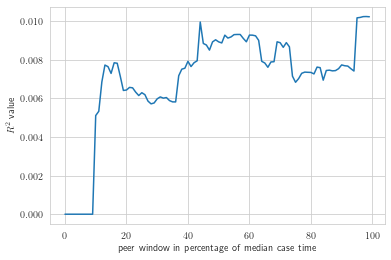

In [54]:
from matplotlib import pyplot as plt
from importlib import reload

plt = reload(plt)

plt.plot(avg_r_squared)
plt.xlabel('peer window in percentage of median case time')
plt.ylabel('\(R^2\) value')
plt.rc('text', usetex=True)
plt.savefig('peer-case-r-squared.png', dpi=400)